# Sentiment Analysis: Customer Feedback

# Notebook 2: Naive Bayes Classifier Model

In this notebook, customer feedback/comments/reviews are analyzed to determine whether they are positive, negative, or neutral using the Naive Bayes Classifier (NBC) model.

## Setup

In [1]:
import os

# libraries to work with data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# libraries for machine learning
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

# libraries for saving/loading models
import joblib
import pickle

## Loading Clean Datasets

In [2]:
df_train = pd.read_pickle('./datasets/final_training_dataset.pkl')
df_train

,review_text,sentiment
0,wow love place,1
1,crust not good,0
2,not tasti textur nasti,0
3,stop late may bank holiday rick steve recommen...,1
4,select menu great price,1
...,...,...
25895,disappoint qualiti,0
25896,amaz experi highli recommend,1
25897,fast deliveri great packag,1
25898,great valu money,1


In [3]:
df_test = pd.read_pickle('./datasets/final_testing_dataset.pkl')
df_test

,review_text,sentiment
0,fantast spot even quit cocktail swell host yel...,1
1,love love love calamari good spici endless lis...,1
2,love place stiff martini cocktail cheap drink ...,1
3,everyth great cocktail bar great locat ambianc...,1
4,come pirat game around 530ish even get lucki t...,1
...,...,...
4316,wife catch show golden nugget hear good thing ...,0
4317,dumb show ever seen never laugh minut realiz w...,0
4318,girlfriend go show absolut terriblenot funni n...,0
4319,restroom look like bombard improvis shack amid...,0


## Naive Bayes Classifier: Data Splitting

The training dataset is split into features (X) and target (y). Each of these is further divided into a training set (X_train, y_train) and a validation set (X_val, y_val) to evaluate the model's generalization ability. A separate test set (X_test, y_test) is kept aside and does not need further division.

The **labels (y)** in the training, validation, and test datasets **must be integers** because scikit-learn's `MultinomialNB` requires numeric (integer) labels.

In [4]:
# features and labels for the training dataset
X = df_train['review_text']  # raw text, not vectorized
y = df_train['sentiment'].values.astype(int)  # convert to integers

# split the training dataset into validation dataset
raw_X_train, raw_X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# features and labels for the testing dataset
raw_X_test = df_test['review_text']  # raw text, not vectorized
y_test = df_test['sentiment'].values.astype(int)  # convert to integers

# check the shape and data type of the datasets before and after splitting
elements = {
    "X": X,
    "raw_X_train": raw_X_train,
    "raw_X_val": raw_X_val,
    "raw_X_test": raw_X_test,
    "y": y,
    "y_train": y_train,
    "y_val": y_val,
    "y_test": y_test
}

for name, element in elements.items():
    print(f"{name} shape: {element.shape}")
    print(f"{name} data type: {element.dtype}\n")

X shape: (25900,)
X data type: object

raw_X_train shape: (20720,)
raw_X_train data type: object

raw_X_val shape: (5180,)
raw_X_val data type: object

raw_X_test shape: (4321,)
raw_X_test data type: object

y shape: (25900,)
y data type: int64

y_train shape: (20720,)
y_train data type: int64

y_val shape: (5180,)
y_val data type: int64

y_test shape: (4321,)
y_test data type: int64



After splitting the dataset, the class distributions for the training and validation datasets should be similar since they come from the same dataset. The test dataset, however, can have a different distribution as it comes from a completely separate dataset, which is acceptable in real-world scenarios.

In [5]:
# get distributions
train_dist = Counter(y_train)
val_dist = Counter(y_val)
test_dist = Counter(y_test)

# calculate totals
train_total = len(y_train)
val_total = len(y_val)
test_total = len(y_test)

# print to compare distributions with percentages
print("training dataset label distribution:")
for label, count in sorted(train_dist.items()):
    percentage = (count / train_total) * 100
    print(f"  (Class {label}): {count} ({percentage:.2f}%)")
print(f"  Total: {train_total:,}")

print("\nvalidation dataset label distribution:")
for label, count in sorted(val_dist.items()):
    percentage = (count / val_total) * 100
    print(f"  (Class {label}): {count} ({percentage:.2f}%)")
print(f"  Total: {val_total:,}")

print("\ntesting dataset label distribution:")
for label, count in sorted(test_dist.items()):
    percentage = (count / test_total) * 100
    print(f"  (Class {label}): {count} ({percentage:.2f}%)")
print(f"  Total: {test_total:,}")

training dataset label distribution:
  (Class 0): 8271 (39.92%)
  (Class 1): 8369 (40.39%)
  (Class 2): 4080 (19.69%)
  Total: 20,720

validation dataset label distribution:
  (Class 0): 2070 (39.96%)
  (Class 1): 2105 (40.64%)
  (Class 2): 1005 (19.40%)
  Total: 5,180

testing dataset label distribution:
  (Class 0): 1332 (30.83%)
  (Class 1): 2989 (69.17%)
  Total: 4,321


## Naive Bayes Classifier: Encoding

The `CountVectorizer` is a text feature extraction method from the `scikit-learn` library. It is used to **transform a collection of review texts into a bag-of-words model**, represented as a sparse matrix. The process is as follows:
- `fit()`: Learns the vocabulary from the training data (does not create a matrix yet).
- `transform()`: Encodes text into a bag-of-words model, represented as a sparse matrix.
- `fit_transform()`: Combines both steps.

***

Each row of the matrix corresponds to a review, and each column corresponds to a unique word in the entire collection of reviews. The **value at each position represents the number of occurrences** of that word in the review.

Example: Given a review "this is is not good":
- "this is is not good" &#8594; {this: 1 occurrence, is: 2 occurrences, not: 1 occurrence, good: 1 occurrence} &#8594; [1 2 1 1]
- row: "this is is not good"
- column: [1 2 1 1] (where position 0=this, position 1=is, position 2=not, position 3=good)

***

It **does not perform padding** as it only creates <u>fixed-size</u> feature vectors <u>(not sequences)</u> for each review. The length of these vectors is determined by the total number of unique words across all reviews (i.e., the vocabulary). The number of features can be controlled by setting the `max_features` parameter.

Example: If `max_features = 3`, the method will only consider the 3 most frequent words across all reviews, ignoring any additional words if they exceed the `max_features` limit:
- "this is not good" &#8594; {this: 1, is: 1, not: 1} &#8594; [1 1 1]

***

Since it only **counts the occurrence of words** in each review and **ignores their order**, different word sequences that contain the same words will produce identical feature vectors.

Example:
- "this is not good" &#8594; {this: 1, is: 1, not: 1, good: 1} &#8594; [1 1 1 1]
- "this good is not" &#8594; {this: 1, is: 1, not: 1, good: 1} &#8594; [1 1 1 1]

In [6]:
# initialize CountVectorizer with the default max_features
cv = CountVectorizer()  # max_features=None

# training data: fit and transform
X_train = cv.fit_transform(raw_X_train).toarray()

# save the CountVectorizer which contains the vocabulary
os.makedirs('./text_transformers', exist_ok=True)
with open('./text_transformers/count_vectorizer.pkl', 'wb') as f:
    pickle.dump(cv, f)

# validation data: only transform (using vocabulary from training)
X_val = cv.transform(raw_X_val).toarray()

# print the feature names or unique words
print(f"feature names: {cv.get_feature_names_out()}")
print()

# print the matrix dimensions
print(f"train matrix dimensions: {X_train.shape}")
print(f"val matrix dimensions: {X_val.shape}")

feature names: ['15' '34th' '35' ... 'yum' 'yummi' 'zero']

train matrix dimensions: (20720, 1327)
val matrix dimensions: (5180, 1327)


## Naive Bayes Classifier: Model Training

The `MultinomialNB()` classifier is used because it does not assume the data follows a Gaussian distribution. It works with count data and frequencies, making it particularly suitable for bag-of-words models commonly used in text classification.

The `alpha` parameter controls the smoothing of probabilities, helping to prevent zero probabilities for words not seen in the training data. The higher the alpha, the stronger the smoothing effect.
- $\alpha = 0.1$ &#8594; less smoothing (more sensitive to the training data)
- $\alpha = 1.0$ &#8594; default standard smoothing (Laplace smoothing)
- $\alpha \geq 2.0$ &#8594; more smoothing (more conservative in fitting to the training data)

In [7]:
# initialize the model with the default alpha
baseline_classifier = MultinomialNB()  # alpha=1.0

# train the model
baseline_classifier.fit(X_train, y_train)

,"alpha alpha: float or array-like of shape (n_features,), default=1.0Additive (Laplace/Lidstone) smoothing parameter(set alpha=0 and force_alpha=True, for no smoothing).",1.0
,"force_alpha force_alpha: bool, default=TrueIf False and alpha is less than 1e-10, it will set alpha to1e-10. If True, alpha will remain unchanged. This may causenumerical errors if alpha is too close to 0... versionadded:: 1.2.. versionchanged:: 1.4 The default value of `force_alpha` changed to `True`.",True
,"fit_prior fit_prior: bool, default=TrueWhether to learn class prior probabilities or not.If false, a uniform prior will be used.",True
,"class_prior class_prior: array-like of shape (n_classes,), default=NonePrior probabilities of the classes. If specified, the priors are notadjusted according to the data.",None


## Naive Bayes Classifier: Model Evaluation

The baseline model, that uses default values for hyperparameters, is evaluated on the validation dataset.

In [8]:
# evaluate accuracy on validation dataset using the baseline model
y_pred_val = baseline_classifier.predict(X_val)
val_accuracy = baseline_classifier.score(X_val, y_val)

print(f"accuracy on validation data with the baseline model: {val_accuracy:.6f}")

accuracy on validation data with the baseline model: 0.991506


## Naive Bayes Classifier: Hyperparameter Tuning

The current baseline model may be improved further by finding optimal hyperparameters through tuning. This optimization can be measured using evaluation metrics such as accuracy score or F1-score. According to the above output, the distributions of classes are as follows:
```output
training dataset label distribution:
  (Class 0): 8271 (39.92%)
  (Class 1): 8369 (40.39%)
  (Class 2): 4080 (19.69%)
  Total: 20,720

validation dataset label distribution:
  (Class 0): 2070 (39.96%)
  (Class 1): 2105 (40.64%)
  (Class 2): 1005 (19.40%)
  Total: 5,180
```

Since the classes are imbalanced (with Neutral class having approximately half the samples of Positive and Negative classes), the **F1-macro score should be used as the primary evaluation measure**, as it provides a better assessment of model performance across all classes compared to accuracy alone.

The two hyperparameters to tune are:
- `max_features` for `CountVectorizer()` object
- `alpha` for `MultinomialNB()` object

To tune `max_features`, the total number of unique features/words (vocabulary size) in the training data is computed first to establish an upper bound for the hyperparameter range.

In [9]:
# check actual vocabulary size
vocab_size = len(cv.vocabulary_)
print(f"total number of unique features/words in the training data: {vocab_size}")

total number of unique features/words in the training data: 1327


The `Pipeline` object expects raw text because it includes the `CountVectorizer` object, which handles text encoding internally. 

In [10]:
# define pipeline
pipeline = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('classifier', MultinomialNB())
])

# define parameter grid
param_grid = {
    'vectorizer__max_features': [500, 800, 1000, 1200, vocab_size],
    'classifier__alpha': [0.1, 0.5, 1.0, 2.0, 5.0]
}

# define scorers
scoring = {
    'f1_macro': 'f1_macro',  # primary metric for optimization
    'accuracy': 'accuracy'   # also track accuracy
}

# create GridSearchCV object
grid_search = GridSearchCV(
    estimator=pipeline,           # the pipeline to optimize
    param_grid=param_grid,        # parameters to try
    cv=5,                         # 5-fold cross-validation
    scoring=scoring,              # metrics to track
    refit='f1_macro',             # refit best model using f1_macro
    n_jobs=-1,                    # use all CPU cores
    verbose=2,                    # print progress
    return_train_score=True       # return training scores for analysis
)

In [11]:
# start hyperparameter tuning
## 5 parameters x 5 parameters = 25 combinations
## 25 combinations x 5-fold cross-validation = 125 fits
grid_search.fit(raw_X_train, y_train)  # use raw text, not vectorized

Fitting 5 folds for each of 25 candidates, totalling 125 fits


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...inomialNB())])
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'classifier__alpha': [0.1, 0.5, ...], 'vectorizer__max_features': [500, 800, ...]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.","{'accuracy': 'accuracy', 'f1_macro': 'f1_macro'}"
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",'f1_macro'
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",5
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold a

In [12]:
# get detailed results (optional)
results_df = pd.DataFrame(grid_search.cv_results_).sort_values('mean_test_f1_macro', ascending=False)
results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__alpha,param_vectorizer__max_features,params,split0_test_f1_macro,split1_test_f1_macro,split2_test_f1_macro,...,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,split0_train_accuracy,split1_train_accuracy,split2_train_accuracy,split3_train_accuracy,split4_train_accuracy,mean_train_accuracy,std_train_accuracy
2,0.259661,0.082933,0.067121,0.025061,0.1,1000,"{'classifier__alpha': 0.1, 'vectorizer__max_fe...",0.993685,0.991881,0.991682,...,0.991216,0.001168,1,0.997044,0.997587,0.997889,0.997466,0.997647,0.997527,0.000278
4,0.283073,0.047487,0.064628,0.009620,0.1,1327,"{'classifier__alpha': 0.1, 'vectorizer__max_fe...",0.993685,0.991280,0.992083,...,0.991216,0.001217,1,0.997527,0.997828,0.998009,0.997708,0.998069,0.997828,0.000198
3,0.264867,0.036585,0.057325,0.013156,0.1,1200,"{'classifier__alpha': 0.1, 'vectorizer__max_fe...",0.993685,0.991280,0.992083,...,0.991216,0.001217,1,0.997527,0.997828,0.998009,0.997708,0.998069,0.997828,0.000198
1,0.332412,0.074851,0.061842,0.003066,0.1,800,"{'classifier__alpha': 0.1, 'vectorizer__max_fe...",0.993484,0.991680,0.991682,...,0.991071,0.001192,4,0.996561,0.996984,0.997225,0.996923,0.997406,0.997020,0.000287
0,0.291131,0.017831,0.093241,0.039489,0.1,500,"{'classifier__alpha': 0.1, 'vectorizer__max_fe...",0.993685,0.991480,0.991081,...,0.990975,0.001318,5,0.995174,0.995958,0.996260,0.995958,0.995898,0.995849,0.000361
7,0.354018,0.133914,0.092874,0.025183,0.5,1000,"{'classifier__alpha': 0.5, 'vectorizer__max_fe...",0.992770,0.991576,0.991673,...,0.990734,0.000898,6,0.995656,0.995958,0.996441,0.996018,0.996199,0.996055,0.000260
8,0.273662,0.100609,0.049400,0.003726,0.5,1200,"{'classifier__alpha': 0.5, 'vectorizer__max_fe...",0.992570,0.991176,0.991673,...,0.990685,0.000948,7,0.996139,0.996199,0.996863,0.996139,0.996561,0.996380,0.000288
9,0.343590,0.084012,0.069413,0.024399,0.5,1327,"{'classifier__alpha': 0.5, 'vectorizer__max_fe...",0.992570,0.991176,0.991673,...,0.990685,0.000948,7,0.996139,0.996199,0.996863,0.996139,0.996561,0.996380,0.000288
6,0.309377,0.031448,0.091233,0.033074,0.5,800,"{'classifier__alpha': 0.5, 'vectorizer__max_fe...",0.992770,0.991376,0.991673,...,0.990589,0.001057,9,0.995294,0.995415,0.995837,0.995415,0.995898,0.995572,0.000246
5,0.235392,0.045716,0.061721,0.012061,0.5,500,"{'classifier__alpha': 0.5, 'vectorizer__max_fe...",0.992971,0.990975,0.991272,...,0.990444,0.001042,12,0.994510,0.994691,0.994932,0.994872,0.994812,0.994764,0.000150


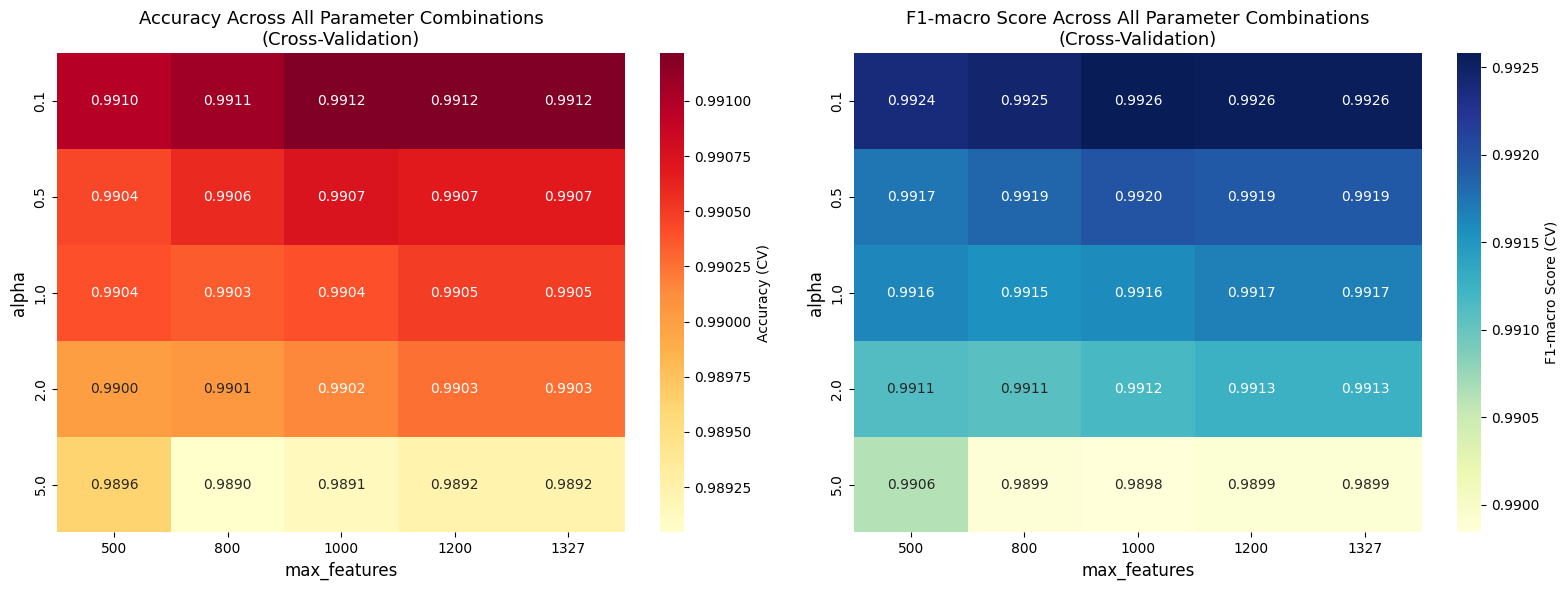

In [13]:
# create matrices for heatmaps
f1_matrix = np.zeros((len(param_grid['classifier__alpha']), len(param_grid['vectorizer__max_features'])))
acc_matrix = np.zeros((len(param_grid['classifier__alpha']), len(param_grid['vectorizer__max_features'])))

for idx, row in results_df.iterrows():
    max_feat = row['param_vectorizer__max_features']
    alpha = row['param_classifier__alpha']
    
    i = param_grid['classifier__alpha'].index(alpha)
    j = param_grid['vectorizer__max_features'].index(max_feat)
    
    # get scores from dataframe
    f1_matrix[i, j] = row['mean_test_f1_macro']
    acc_matrix[i, j] = row['mean_test_accuracy']

# create heatmaps
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# plot F1-macro heatmap
sns.heatmap(f1_matrix, annot=True, fmt='.4f', cmap='YlGnBu',
            xticklabels=param_grid['vectorizer__max_features'], yticklabels=param_grid['classifier__alpha'],
            ax=ax2, cbar_kws={'label': 'F1-macro Score (CV)'})
ax2.set_xlabel('max_features', fontsize=12)
ax2.set_ylabel('alpha', fontsize=12)
ax2.set_title('F1-macro Score Across All Parameter Combinations\n(Cross-Validation)', fontsize=13)

# plot accuracy heatmap
sns.heatmap(acc_matrix, annot=True, fmt='.4f', cmap='YlOrRd', 
            xticklabels=param_grid['vectorizer__max_features'], yticklabels=param_grid['classifier__alpha'],
            ax=ax1, cbar_kws={'label': 'Accuracy (CV)'})
ax1.set_xlabel('max_features', fontsize=12)
ax1.set_ylabel('alpha', fontsize=12)
ax1.set_title('Accuracy Across All Parameter Combinations\n(Cross-Validation)', fontsize=13)

plt.tight_layout()
plt.show()

After fitting with `GridSearchCV`, the `GridSearchCV` object automatically delegates to `best_estimator_` (the best `Pipeline` with optimal parameters) when calling methods like `score()` or `predict()`, making it convenient to use as if it were the best model itself.

In [14]:
# get results
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# select the best model
best_classifier = grid_search.best_estimator_

# evaluate accuracy on validation dataset using the best model
val_accuracy = best_classifier.score(raw_X_val, y_val)  # use raw text, not vectorized
print(f"accuracy on validation data with the best model: {val_accuracy:.6f}")

Best parameters: {'classifier__alpha': 0.1, 'vectorizer__max_features': 1000}
Best cross-validation score: 0.9926
accuracy on validation data with the best model: 0.991892


The accuracy is improved by using the optimal hyperparameters.

```output
accuracy on validation data with the baseline model: 0.991506
accuracy on validation data with the best model: 0.991892
```

## Naive Bayes Classifier: Confusion Matrix

class names: ['Negative', 'Positive', 'Neutral']


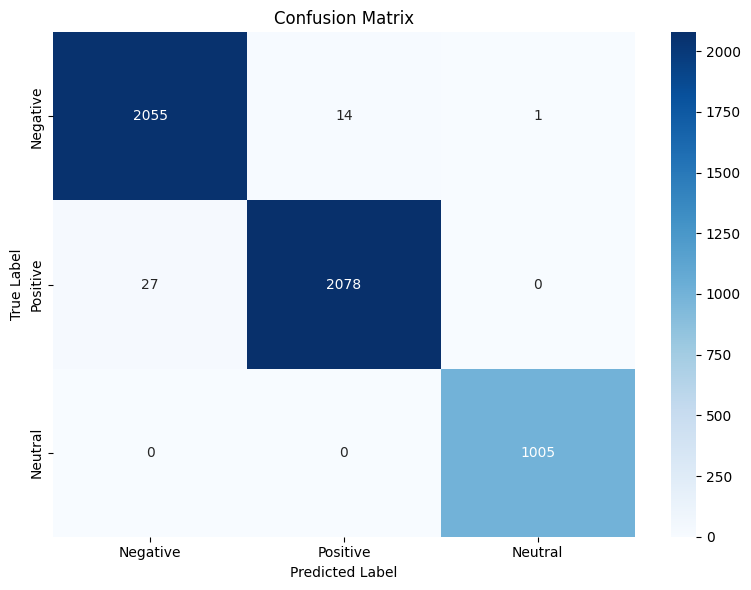

In [15]:
# make predictions using the best model
y_pred_val = best_classifier.predict(raw_X_val)  # use raw text, not vectorized

# create a confusion matrix
cm = confusion_matrix(y_val, y_pred_val)

## actual labels
class_names = []

## get unique classes (integers)
classes = sorted(df_train['sentiment'].unique())

## map integers to actual labels
for c in classes:
    if c == 0:
        class_names.append("Negative")
    elif c == 1:
        class_names.append("Positive")
    elif c == 2:
        class_names.append("Neutral")

print(f"class names: {class_names}")

# create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

## Naive Bayes Classifier: Model Testing

After fine-tuning the hyperparameters, the model is evaluated using the testing dataset.

accuracy on test data with the best model: 0.756769
F1-macro on test data with the best model: 0.498404


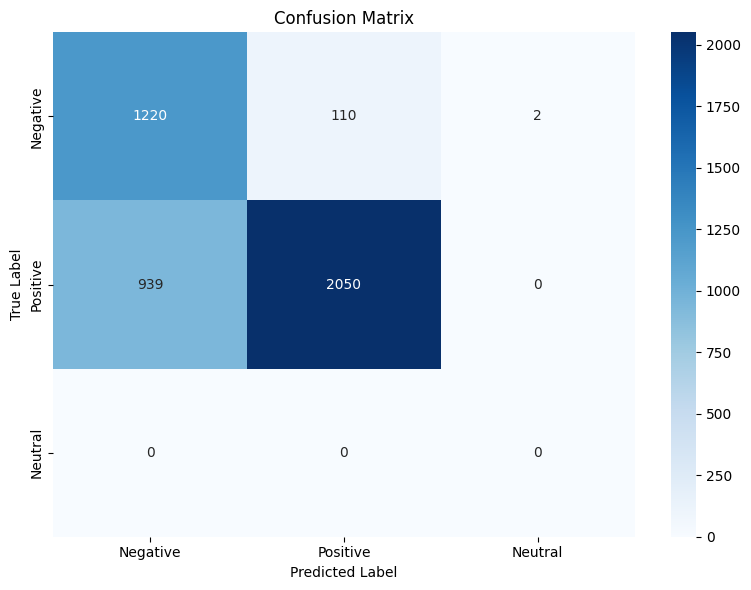

In [16]:
# make predictions using the best model
y_pred_test = grid_search.predict(raw_X_test)  # use raw text, not vectorized

# evaluate scores on testing dataset
test_accuracy = accuracy_score(y_test, y_pred_test)
test_f1_macro = f1_score(y_test, y_pred_test, average='macro')

print(f"accuracy on test data with the best model: {test_accuracy:.6f}")
print(f"F1-macro on test data with the best model: {test_f1_macro:.6f}")

# create a confusion matrix
cm = confusion_matrix(y_test, y_pred_test)

# create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

The model predicts negative or positive with roughly equal likelihood. When it makes a prediction, it can identify positive instances better than negative ones. It learned to ignore the neutral class (almost always predicts negative or positive) because there are very few neutral examples in training.

## Naive Bayes Classifier: Model Testing with Any Reviews

In [17]:
review_to_predict = str(input("Enter a review: "))
prediction = best_classifier.predict([review_to_predict])[0]

print()

if prediction == 0:
    print(f"Prediction: {class_names[0]}")
elif prediction == 1:
    print(f"Prediction: {class_names[1]}")
elif prediction == 2:
    print(f"Prediction: {class_names[2]}")

Enter a review: It is a nice place to spend your night.

Prediction: Positive


## Naive Bayes Classifier: Saving Model

The model can be saved in any file format, but `.joblib` is used here to indicate that the saving process is done with the joblib library. This is because scikit-learn models, including Naive Bayes, do not have a built-in `save()` method. Instead, `joblib.dump()` is used to save the trained model to a file, which can later be loaded for inference or further use.

In [18]:
joblib.dump(best_classifier, './models/sentiment_analysis_nbc_model.joblib')

['./models/sentiment_analysis_nbc_model.joblib']

This notebook is done by `La Wun Nannda`.